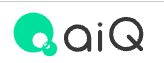

[disclaimer](./disclaimer.txt/)

# ALTERNATIVE DATA Evaluation Demo

## Evaluate aiQ POS ELEC Goods using aiQ Lab Alt Data Evaluation Tool

In [1]:
%load_ext autoreload
%autoreload 2

### Step1: Import Library

In [2]:
import sys
import numpy as np
import pandas as pd
import plotly.io
import plotly.express as px

for_html = False
if for_html == True:
    plotly.offline.init_notebook_mode()
else:
    plotly.io.renderers.default = 'iframe'

sys.path.append('../..')

from utils.shortcut import single_dataset as sc
from aiq_strategy_robot.data.data_accessor import DAL
from utils.shortcut.path import DEFAULT_DIR

In [3]:
import pandas as pd

In [4]:
from aiq_strategy_robot.data.FINNHUB import (
    load_finnhub_equity_prices,
    load_finnhub_dividends,
    load_finnhub_stock_splits,
    load_finnhub_equity_data,
    load_finnhub_symbol_lookup
)

In [5]:
sdh = DAL()

### Step2: Load Data
Retrieve each factor and register it to `handler`.
> In this sample, retrieval and registration operations are omitted.

In [6]:
sdh.extract.clear()

#  Load Alternative Data
data_id_alt = sc.register_elec_data(sdh, data_dir=DEFAULT_DIR)

#  Load Fundamental Data
data_id_funda = sc.register_fundamental_data(sdh)

Check coverage ratio

In [7]:
variable = 'pos_sales'
lower_bound = 0.9
start_date = pd.Timestamp('2020-01-01')
end_date = pd.Timestamp('2023-12-31')

In [8]:
dfpos = sdh.get_raw_data(data_id_alt)

In [9]:
dfcheck = dfpos[[variable]].unstack('ticker').droplevel(0, axis=1)
if start_date:
    dfcheck = dfcheck.loc[dfcheck.index > start_date]
if end_date:
    dfcheck = dfcheck.loc[dfcheck.index < end_date]
dfcheck.dropna(how='all', axis=1, inplace=True)
num_obs = len(dfcheck)
dfcount = dfcheck.count()
list_dense_tickers = dfcount.loc[dfcount / num_obs > lower_bound].index.tolist()

# showing the list of tickers that have more than `lower_bound`
print(f'Tickers with observations for more than {lower_bound *  100}% of datetime after {start_date}.')
print(f'number of dense tickers: {len(list_dense_tickers)}')

Tickers with observations for more than 90.0% of datetime after 2020-01-01 00:00:00.
number of dense tickers: 70


### load stock price from finnhub.

In [10]:
target_stock_ticker = sdh.get_raw_data(data_id_alt).index.get_level_values('ticker').unique().to_list()

In [ ]:
data_id_mkt = sc.load_finnhub_equity_data_fixed_ticker(sdh, data_dir=DEFAULT_DIR)

In [ ]:
display(sdh.get_raw_data(data_id_alt).tail())
display(sdh.get_raw_data(data_id_funda).tail())
display(sdh.get_raw_data(data_id_mkt).tail())

### Step3: Correlation Analysis

In [ ]:
from aiq_strategy_robot.evaluator import AltDataEvaluator

# Initialize AltDataEvaluator
ade = AltDataEvaluator(sdh)

##### Visualisation of Alt Data and Fundamental data for any one ticker

In [ ]:
sdh.transform.clear()
funda_Q_ids = sdh.transform.resample(data_id=data_id_funda, rule='Q', func='last').variable_ids
alt_Q_ids = sdh.transform.resample(data_id=data_id_alt, rule='Q', func='mean').variable_ids\
    + sdh.transform\
        .multiply(data_id=data_id_alt, x1field="pos_sales", x2field="unit_price", name="sales*uprice")\
        .resample(rule='Q', func='mean').variable_ids

In [ ]:
features = list(sdh.get_raw_data(data_id_alt).columns) + ['sales*uprice']
features

In [ ]:
sample_target = "7984-JP"

In [ ]:
sdh.show_line_one_target(
    target=sample_target, #どの ticker のデータを描画するかを決めます
    y=funda_Q_ids[0], #y軸に表示するデータを variable_id で指定します
    X=alt_Q_ids, #x軸に表示するデータを variable_id の list で指定します（複数のグラフを一気に表示する時に list にします）
    col_num=2, #1行にいくつのグラフを表示するかを決めます
    vname_len_limit=50, #タイトルにXのvariable_id の変数名が表示されますが、表示を短くするために文字数を指定します
)

##### Visualisation of Alt data shifted in several patterns.

In [ ]:
# alt_Q_shift_03_ids = sdh.transform.shift(data_id=data_id_alt, periods=3).resample(rule='Q', func='mean').variable_ids
# alt_Q_shift_04_ids = sdh.transform.shift(data_id=data_id_alt, periods=4).resample(rule='Q', func='mean').variable_ids
# alt_Q_shift_05_ids = sdh.transform.shift(data_id=data_id_alt, periods=5).resample(rule='Q', func='mean').variable_ids
# alt_Q_shift_06_ids = sdh.transform.shift(data_id=data_id_alt, periods=6).resample(rule='Q', func='mean').variable_ids
# alt_Q_shift_07_ids = sdh.transform.shift(data_id=data_id_alt, periods=7).resample(rule='Q', func='mean').variable_ids
# alt_Q_shift_08_ids = sdh.transform.shift(data_id=data_id_alt, periods=8).resample(rule='Q', func='mean').variable_ids
# alt_Q_shift_09_ids = sdh.transform.shift(data_id=data_id_alt, periods=9).resample(rule='Q', func='mean').variable_ids
# alt_Q_shift_12_ids = sdh.transform.shift(data_id=data_id_alt, periods=12).resample(rule='Q', func='mean').variable_ids

# mul_ids = sdh.transform.multiply(data_id=data_id_alt, x1field="pos_sales", x2field="unit_price", name="sales*uprice").variable_ids
# alt_Q_shift_03_ids += sdh.transform.shift(fields=mul_ids, periods=3).resample(rule='Q', func='mean').variable_ids
# alt_Q_shift_04_ids += sdh.transform.shift(fields=mul_ids, periods=4).resample(rule='Q', func='mean').variable_ids
# alt_Q_shift_05_ids += sdh.transform.shift(fields=mul_ids, periods=5).resample(rule='Q', func='mean').variable_ids
# alt_Q_shift_06_ids += sdh.transform.shift(fields=mul_ids, periods=6).resample(rule='Q', func='mean').variable_ids
# alt_Q_shift_07_ids += sdh.transform.shift(fields=mul_ids, periods=7).resample(rule='Q', func='mean').variable_ids
# alt_Q_shift_08_ids += sdh.transform.shift(fields=mul_ids, periods=8).resample(rule='Q', func='mean').variable_ids
# alt_Q_shift_09_ids += sdh.transform.shift(fields=mul_ids, periods=9).resample(rule='Q', func='mean').variable_ids
# alt_Q_shift_12_ids += sdh.transform.shift(fields=mul_ids, periods=12).resample(rule='Q', func='mean').variable_ids

In [ ]:
sdh.get_raw_data(data_id_alt)

In [ ]:
vid_alt = sdh.transform.raw(data_id=data_id_alt).variable_ids\
    + sdh.transform.multiply(data_id=data_id_alt, x1field="pos_sales", x2field="unit_price", name="sales*uprice").variable_ids

In [ ]:
alt_Q_shift_03_ids = sdh.transform.shift(fields=vid_alt, periods=3).resample(rule='Q', func='mean').variable_ids
alt_Q_shift_04_ids = sdh.transform.shift(fields=vid_alt, periods=4).resample(rule='Q', func='mean').variable_ids
alt_Q_shift_05_ids = sdh.transform.shift(fields=vid_alt, periods=5).resample(rule='Q', func='mean').variable_ids
alt_Q_shift_06_ids = sdh.transform.shift(fields=vid_alt, periods=6).resample(rule='Q', func='mean').variable_ids
alt_Q_shift_07_ids = sdh.transform.shift(fields=vid_alt, periods=7).resample(rule='Q', func='mean').variable_ids
alt_Q_shift_08_ids = sdh.transform.shift(fields=vid_alt, periods=8).resample(rule='Q', func='mean').variable_ids
alt_Q_shift_09_ids = sdh.transform.shift(fields=vid_alt, periods=9).resample(rule='Q', func='mean').variable_ids
alt_Q_shift_12_ids = sdh.transform.shift(fields=vid_alt, periods=12).resample(rule='Q', func='mean').variable_ids

In [ ]:
sdh.transform.get_variable_name(alt_Q_shift_03_ids[0]), sdh.transform.get_variable_name(alt_Q_shift_03_ids[4]), 

In [ ]:
# View Sales vs Pos Sales
sdh.show_line_one_target(
    target=sample_target,
    y=funda_Q_ids[0],
    X=[alt_Q_shift_03_ids[0], alt_Q_shift_03_ids[4],
       alt_Q_shift_04_ids[0], alt_Q_shift_04_ids[4], 
       alt_Q_shift_05_ids[0], alt_Q_shift_05_ids[4],
       alt_Q_shift_06_ids[0], alt_Q_shift_06_ids[4], 
       alt_Q_shift_07_ids[0], alt_Q_shift_07_ids[4], 
       alt_Q_shift_08_ids[0], alt_Q_shift_08_ids[4], 
       alt_Q_shift_09_ids[0], alt_Q_shift_09_ids[4],
       alt_Q_shift_12_ids[0], alt_Q_shift_12_ids[4]],
    col_num=2
)

##### Logarithmic transformation and correlation checks.

In [ ]:
sales_id                        = sdh.transform.log_diff(fields=funda_Q_ids, periods=4).variable_ids[-1]
alt_Q_shift_00_logdiff_ids      = sdh.transform.log_diff(fields=alt_Q_ids,          periods=4).variable_ids
alt_Q_shift_03_logdiff_ids      = sdh.transform.log_diff(fields=alt_Q_shift_03_ids, periods=4).variable_ids
alt_Q_shift_04_logdiff_ids      = sdh.transform.log_diff(fields=alt_Q_shift_04_ids, periods=4).variable_ids
alt_Q_shift_05_logdiff_ids      = sdh.transform.log_diff(fields=alt_Q_shift_05_ids, periods=4).variable_ids
alt_Q_shift_06_logdiff_ids      = sdh.transform.log_diff(fields=alt_Q_shift_06_ids, periods=4).variable_ids
alt_Q_shift_07_logdiff_ids      = sdh.transform.log_diff(fields=alt_Q_shift_07_ids, periods=4).variable_ids
alt_Q_shift_08_logdiff_ids      = sdh.transform.log_diff(fields=alt_Q_shift_08_ids, periods=4).variable_ids
alt_Q_shift_09_logdiff_ids      = sdh.transform.log_diff(fields=alt_Q_shift_09_ids, periods=4).variable_ids
alt_Q_shift_12_logdiff_ids      = sdh.transform.log_diff(fields=alt_Q_shift_12_ids, periods=4).variable_ids
sales_diff_id                   = sdh.transform.log_diff(fields=funda_Q_ids, periods=4).diff(periods=1).variable_ids[-1]
alt_Q_shift_00_logdiff_diff_ids = sdh.transform.log_diff(fields=alt_Q_ids,          periods=4).diff(periods=1).variable_ids
alt_Q_shift_03_logdiff_diff_ids = sdh.transform.log_diff(fields=alt_Q_shift_03_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_04_logdiff_diff_ids = sdh.transform.log_diff(fields=alt_Q_shift_04_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_05_logdiff_diff_ids = sdh.transform.log_diff(fields=alt_Q_shift_05_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_06_logdiff_diff_ids = sdh.transform.log_diff(fields=alt_Q_shift_06_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_07_logdiff_diff_ids = sdh.transform.log_diff(fields=alt_Q_shift_07_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_08_logdiff_diff_ids = sdh.transform.log_diff(fields=alt_Q_shift_08_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_09_logdiff_diff_ids = sdh.transform.log_diff(fields=alt_Q_shift_09_ids, periods=4).diff(periods=1).variable_ids
alt_Q_shift_12_logdiff_diff_ids = sdh.transform.log_diff(fields=alt_Q_shift_12_ids, periods=4).diff(periods=1).variable_ids

# Check application of method chain.
sdh.transform.show_method_chain()

##### Calculation of correlations.

In [ ]:
rho_pool = pd.DataFrame()
rho_pool['n_shift=00'] = ade.compu_rho(alt_Q_shift_00_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=03'] = ade.compu_rho(alt_Q_shift_03_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=04'] = ade.compu_rho(alt_Q_shift_04_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=05'] = ade.compu_rho(alt_Q_shift_05_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=06'] = ade.compu_rho(alt_Q_shift_06_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=07'] = ade.compu_rho(alt_Q_shift_07_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=08'] = ade.compu_rho(alt_Q_shift_08_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=09'] = ade.compu_rho(alt_Q_shift_09_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=12'] = ade.compu_rho(alt_Q_shift_12_logdiff_ids, sales_id, rename_features=features)
rho_pool['n_shift=00_diff=1'] = ade.compu_rho(alt_Q_shift_00_logdiff_diff_ids, sales_diff_id, rename_features=features)
rho_pool['n_shift=03_diff=1'] = ade.compu_rho(alt_Q_shift_03_logdiff_diff_ids, sales_diff_id, rename_features=features)
rho_pool['n_shift=04_diff=1'] = ade.compu_rho(alt_Q_shift_04_logdiff_diff_ids, sales_diff_id, rename_features=features)
rho_pool['n_shift=05_diff=1'] = ade.compu_rho(alt_Q_shift_05_logdiff_diff_ids, sales_diff_id, rename_features=features)
rho_pool['n_shift=06_diff=1'] = ade.compu_rho(alt_Q_shift_06_logdiff_diff_ids, sales_diff_id, rename_features=features)
rho_pool['n_shift=07_diff=1'] = ade.compu_rho(alt_Q_shift_07_logdiff_diff_ids, sales_diff_id, rename_features=features)
rho_pool['n_shift=08_diff=1'] = ade.compu_rho(alt_Q_shift_08_logdiff_diff_ids, sales_diff_id, rename_features=features)
rho_pool['n_shift=09_diff=1'] = ade.compu_rho(alt_Q_shift_09_logdiff_diff_ids, sales_diff_id, rename_features=features)
rho_pool['n_shift=12_diff=1'] = ade.compu_rho(alt_Q_shift_12_logdiff_diff_ids, sales_diff_id, rename_features=features)
display(rho_pool.xs('t-val', level=1).sort_values(rho_pool.columns[0], ascending=False))

##### Select the top 5 most highly correlated features

In [ ]:
rho_time = ade.compu_rho(
    alt_Q_shift_06_logdiff_diff_ids,
    sales_diff_id, by='ticker',
    rename_features=features,
    min_nsample=30
    )
rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).head()

In [ ]:
top3tickers = rho_time.T.xs('t-val', level=1).sort_values('pos_sales', ascending=False).index[:3]

sdh.show_scatter_per_target(
    y=sales_diff_id,
    x=alt_Q_shift_06_logdiff_diff_ids[0],
    targets=top3tickers,
    col_num=3,
    vname_len_limit=25,
)

In [ ]:
top3tickers = rho_time.T.xs('t-val', level=1).sort_values('sales*uprice', ascending=False).index[:3]

sdh.show_scatter_per_target(
    y=sales_diff_id,
    x=alt_Q_shift_00_logdiff_diff_ids[4],
    targets=top3tickers,
    col_num=3,
    vname_len_limit=30,
)

### Step4: Quantile Backtest
Back-testing using the most highly correlated features against market data.

In [ ]:
close_ret = sdh.transform\
    .resample(data_id=data_id_mkt, rule='D', fields='close', func='last')\
    .dropna(how='all')\
    .log_diff(periods=1, names='ret')\
    .variable_ids[0]

In [ ]:
sma_period = 14
min_period = int(max(np.floor(sma_period * 5 / 7), 1))
proto_trans_vid = sdh.transform\
        .multiply(data_id=data_id_alt, x1field="pos_sales", x2field="unit_price", name="sales*uprice")\
        .resample(rule='D', func='last')\
        .sma(periods=sma_period, min_periods=min_period)\
        .reindex(label=close_ret)\
        .log_diff(periods=252)\
        .shift(periods=8)\
        .variable_ids[0]

In [ ]:
# define the parameters for factor choice.
nq = 3
exe_cost = 0.0005

In [ ]:
sdh.transform.get_variable_name(proto_trans_vid)

In [ ]:
dfqret, stats, dfsigqt = ade.q_backtest(
    feature=proto_trans_vid,
    actual_return=close_ret,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)